### Imports:

In [1]:
from numpy import sin, cos, arctan, linspace, pi, array
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import sleep
%matplotlib notebook

### Helper functions:

In [2]:
def get_arg(z):

    if z.re == 0:
        if z.im == 0:
            return 0
        elif z.im> 0:
            return 0.5*pi
        else:
            return -0.5*pi

    elif z.re > 0:
        return arctan(z.im/z.re)

    elif z.im > 0:
        return pi + arctan(z.im/z.re)

    else: 
        return -pi + arctan(z.im/z.re)

def get_mod(z):

    return (z.re**2 + z.im**2)**0.5

def center_list(t):
    med = t[int(len(t)/2)]
    return array([i-med for i in t])

### Complex number class:

In [3]:
class Complex:

    def __init__(self, re=None, im=None, mod=None, arg=None):

        if None not in (re, im):
            self.re = re
            self.im = im
            self.mod = get_mod(self)
            self.arg = get_arg(self)
            
        else:
            self.arg = arg
            self.mod = mod
            self.re = mod * cos(arg)
            self.im = mod * sin(arg)
        
    def re(self):
        return self._re
    
    def im(self):
        return self._im

    def __str__(self):

        if self.im == 1:
            im_str = ''
        elif self.im == -1:
            im_str = '-'
        else:
            im_str = str(self.im)

        return "{}{}{}i".format(str(self.re), '+' if self.im >= 0 else '', im_str)

    def __add__(self, other):
        
        if type(other) == Complex:
            return Complex(re=self.re+other.re, im=self.im+other.im)
        
        else: 
            return Complex(re=self.re+other, im=self.im)
        
    def __radd__(self, other):
        
        return self.__add__(other)
    
    def __mul__ (self, other):
        
        if type(other) == Complex:
            return Complex(mod=self.mod*other.mod, arg=self.arg+other.arg)
        
        else:
            return Complex(mod=self.mod*other, arg=self.arg)
        
    def __rmul__ (self, other):
        
        return self.__mul__(other)
    
# Shorthand function for creating a Complex object using its modulus and argument.
# Would be written mathematically as mod*e**(i*arg).
c_exp = lambda scale, arg: scale * Complex(mod=1, arg=arg)

<h3><u>The wrapping function and getting its coordinates</u></h3>

The `get_wrapped` function essentially wraps `g` (the audio input over time) around the pole of an Argand diagram, cycling clockwise at a rate of `nu` cycles per second. In this way, the complex outputs the `get_wrapped` function returns have a modulus equal to `g` at each time `t` (where `t` is also their argument). We will refer to this function as the 'wrapping' function.

Similarly, the `get_wrap_coords` function gets the coordinates for a polar curve with a radius equal to the `g` at each time `t` (where `t` is also the angle), cycling clockwise at a rate of `nu` cycles per second.

In [4]:
def get_wrapped(g, t, nu, start=None, end=None, num=None):
    
    start = min(t) if start is None else start
    end = max(t) if end is None else end
    
    len_t = len(t)
    num = len_t if num is None else num
    
    idxs = []
    for i in range(len_t):
        if t[i] >= start and t[i] <= end:
            idxs.append(i)
            
    idxs_len = len(idxs)
    
    step = int(idxs_len/num)
    step = 1 if step == 0 else step
            
    return [c_exp(g[i], -2*pi * nu * t[i]) for i in range(0, idxs_len, step)], start, end, num
    
def get_wrap_coords(g, t, nu, start=None, end=None, num=None):
    
    complex_set, _, _, _,  = get_wrapped(g, t, nu, start, end, num)
    return [z.re for z in complex_set], [z.im for z in complex_set]

<h3><u>The Fourier transform function</u></h3>

The `F` function performs the Fourier transform on `g` for a wrapping frequency `nu`. However, instead of integrating from -∞ to +∞ (the entire range over which a sinusoid of that frequency could have an effect within `g`), it performs the trapezium rule with `num` strips for the desired time limits of `g`.

The "center" of the wrapping function between two values of `t` is the mean of all its outputs between these values. In this way, it is equal to this integral divided by the difference between the limits. Therefore, the output of `F` has the same, more pronounced, following properties of the center:

As `nu` approaches the frequency of a sinusoid found in `g`, the distance this center is found from the pole increases (as the wrapping and sinusoid cycles become more coherent such that maxima and minima of the wrapping function occur at two smaller opposing ranges of `t`, shifting the center towards the values of `t` where maxima occur). This distance (directly proportional to the amplitude of the frequency) is at a maximum (as the maxima and minima only occur at fixed opposing values of `t`) when the wrapping and sinusoid frequency are equal.

At this point, they are completely coherent such that the values of `t` where maxima occur at a fixed phase difference from the start of the wrapping cycles. As the wrapping cycles have an absolute phase of 0, this phase difference between the wrapping and sinusoid cycles is equal to the absolute phase of the sinusoid. As such, it is given by the argument of this center (i.e. the angle through the wrapping cycle at which these maxima occur).

In [9]:
def F_func(g, t, nu, start=None, end=None, num=None):
    
    y, start, end, num = get_wrapped(g, t, nu, start, end, num)
    h = (end-start)/num
    return 0.5*h*(y[0] + y[-1] + 2*sum(y[1:-1]))

g_func = lambda t: \
3*cos(2*pi*5*t+-1.2*pi) + \
cos(2*pi*7.5*t+-0.3*pi) + \
2*cos(2*pi*20*t+0.7*pi) + \
6

g = g_func(t)
center = F_func(g, t, 2, start, end, num)*(end-start)**-1

<h3><u>Visualising the 'wrapping' function:</u></h3>

<IPython.core.display.Javascript object>


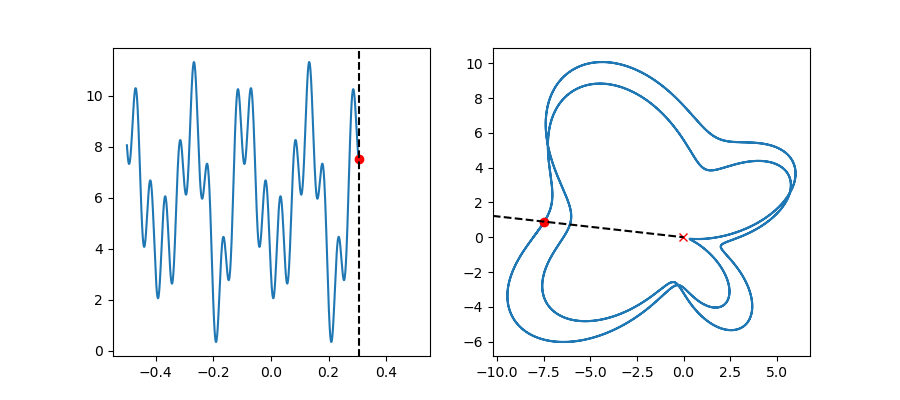

In [15]:
start = -0.5
end = 0.5
num = 1000


t = linspace(start, end, num)



x = [t]
y = [g]
lines = []

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

# Optional reference function
#axes[0].plot(linspace(start, end, num), 9*cos(2*pi*4*x[0]))

# Center of wrapped function
axes[1].plot(center.re, center.im, 'rx')

x_temp, y_temp = get_wrap_coords(g, t, 5)
x.append(x_temp)
y.append(y_temp)

lines = [axes[i].plot(x[i], y[i])[0] for i in range(0, len(axes))]

In [16]:
points = [axis.plot([], [], 'ro')[0] for axis in axes]
ref_lines = [axis.plot([], [], 'k--')[0] for axis in axes]

def animate(count):
    
    for i in range(0, len(lines)):
        
        lines[i].set_data(x[i][:count], y[i][:count])
        points[i].set_data(x[i][count], y[i][count])
        
    ref_lines[0].set_data([x[0][count], x[0][count]], [-50, 50])
    
    if x[1][count] >= 0:
        ref_lines[1].set_data(linspace(0, 50, 2), [0, 50 * (y[1][count]/x[1][count])])
    else:
        ref_lines[1].set_data(linspace(-50, 0, 2), [-50 * (y[1][count]/x[1][count]), 0])
    
anim = FuncAnimation(fig, animate, frames=num-1, interval=10)

<h3><u>Transforming to the frequency domain:</u></h3>

In [ ]:
nu = linspace(-30, 30, 1000)
F = [2*F_func(g, t, i) for i in nu]

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(nu, [z.mod for z in F])

<h3><u>Transforming back to the time domain:</u></h3>

To get `g` back from the output of `F` (i.e. perform an *inverse* Fourier transform), you must compose a function of time where each frequency of sinusoid in the frequency domain is adjusted for its amplitude and phase ($A$ and $\phi$, respectively, which are functions of $\nu$) and summed:

$f(t)= \int_{-\infty}^{\infty} Acos(2\pi\nu t+\phi)d\nu$<br/>
$=\int_{-\infty}^{\infty} A(cos(2\pi\nu t+\phi) + isin(2\pi\nu t+\phi))d\nu - \int_{-\infty}^{\infty} Aisin(2\pi\nu t+\phi)d\nu$<br/>

<IPython.core.display.Javascript object>


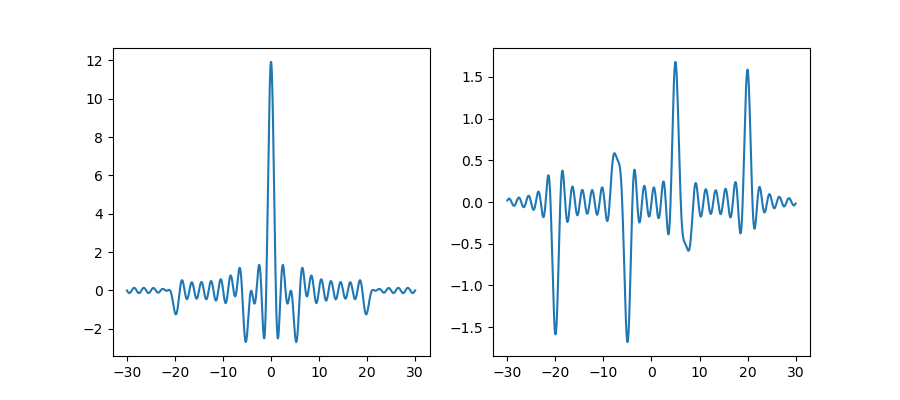

In [849]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
axes[0].plot(nu, [z.re for z in F])
axes[1].plot(nu, [z.im for z in F])

A negative frequency can be understood as the wrapping function cycling at the absolute value of the frequency <u>in the opposite direction</u> (i.e. going anticlockwise instead of clockwise). If the angle of the wrapping function's maximum is $\theta$ when going clockwise, when going anticlockwise, this angle is $2\pi-\theta$ (as the wrapping function cycles the opposite way through the starting sinusoid to reach this maximum). Therefore, the y-coordinate of the maximum of the wrapping function (and thus its center of the wrapping function) is negated whilst the x-coordinate remains the same. Therefore, <u>the real part of a frequency is an even function with frequency while the imaginary part is odd</u>. As such, the second intergral in the last expression equates to 0 and we can continue as follows:

$f(t)=\int_{-\infty}^{\infty} Ae^{(2\pi\nu t+\phi)i}d\nu$<br/>
    $=\int_{-\infty}^{\infty} F(\nu)e^{(2\pi\nu t)i}d\nu$   (as $F(\nu)=Ae^{\phi}$)
    
Therefore, we can just repurpose our old Fourier transform function as it is identical to the inverse (barre `t` not being negated):

In [850]:
g_hat = [F_func(F, nu, i) for i in -1*t] 
#t is negated as F_func does a forward Fourier transform, which negates t again.

<IPython.core.display.Javascript object>


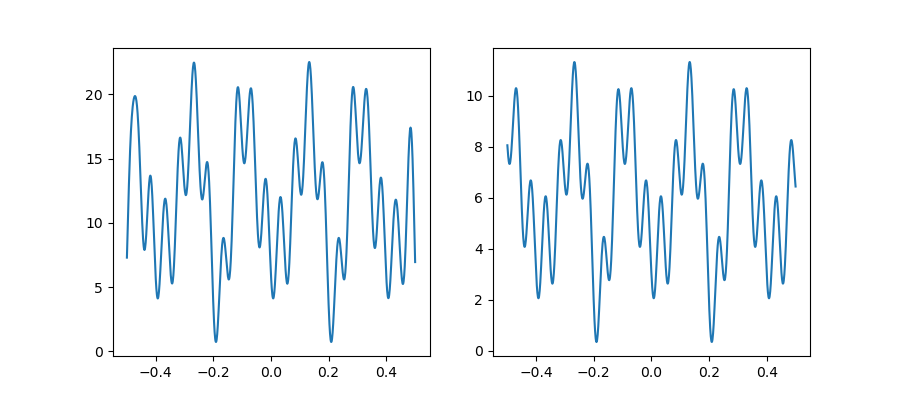

In [851]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
axes[0].plot(t, [z.re for z in g_hat])
axes[1].plot(t, g)

<h3><u>Removing unwanted frequencies:</u></h3>

The `flatten` function removes unwanted frequencies (in the range between `start` and `end`) of an audio input in the frequency domain by changing the complex values at these frequencies to the mean average of the entire input:

In [852]:
def flatten(F, nu, start, end):
    
    F_flattened = []
    
    mean_F = sum(F)*len(F)**-1
    
    for i in range(len(nu)):
        
        if nu[i] >= start and nu[i] <= end:
            F_flattened.append(mean_F)
            
        else:
            F_flattened.append(F[i])
            
    return F_flattened


In [865]:
F_flattened = flatten(F, nu, 10, 30)
F_flattened = flatten(F_flattened, nu, -30, -10)

<IPython.core.display.Javascript object>


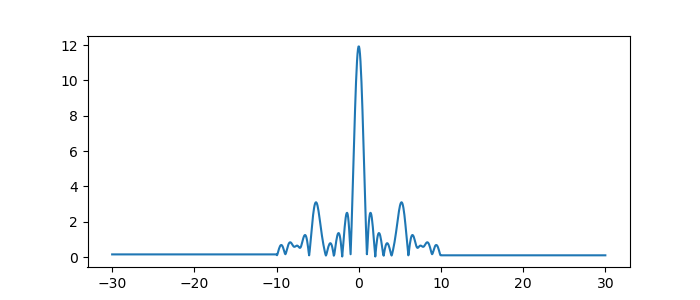

In [866]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(nu, [z.mod for z in F_flattened])

You can then transform this 'flattened' audio input back into the time domain to get the original `g` with these frequencies removed!

In [867]:
g_desire_func = lambda t: \
3*cos(2*pi*5*t+-1.2*pi) + \
cos(2*pi*7.5*t+-0.3*pi) + \
6

g_desire_hat = [F_func(F_flattened, nu, i) for i in t]

<IPython.core.display.Javascript object>


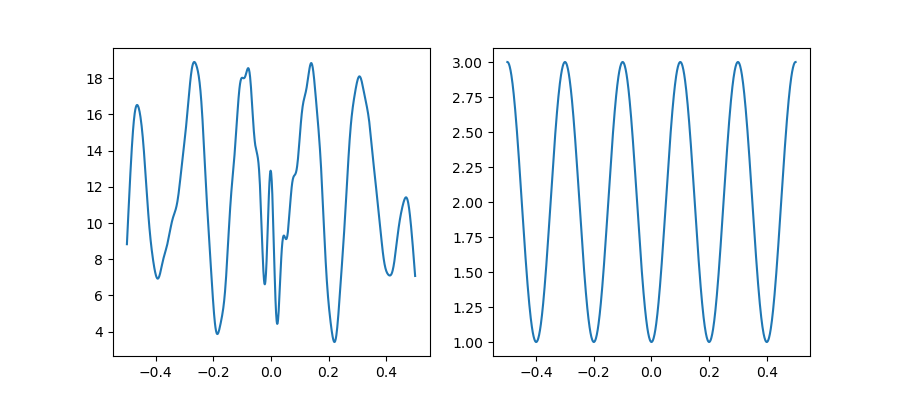

In [868]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

axes[0].plot(-1*t, [z.re for z in g_desire_hat])
axes[1].plot(t, g_desire)